In [30]:
import json
from os import path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  
import seaborn as sns
import numpy as np
from augur.utils import json_to_tree
from Bio import Phylo, SeqIO

import baltic as bt

# Figure 1: Adaptive mutations accumulate continuously over time in known adaptively-evolving proteins

Plot the estimated number of adaptative mutations over time in the receptor-binding protein and polymerase. Plot both the Bhatt rate and the new method for estimating rates of adaptation, which takes into account recurring mutations at the same codon position.

In [4]:
def readin_virus_config(virus):
    config_json = f'config/adaptive_evo_config_{virus}.json'

    with open(config_json) as json_handle:
        configs = json.load(json_handle)
        
    return configs

In [5]:
def standardize_gene_name_reverse(virus, gene):
    
    configs = readin_virus_config(virus)
    
    genes = ['polymerase', 'membrane_fusion', 'receptor_binding']
    gene_names = {x: configs[x]['virus_gene'] for x in genes}
    
    return gene_names[gene]

In [6]:
def standardize_gene_name(virus, gene):
    configs = readin_virus_config(virus)
    
    genes = ['polymerase', 'membrane_fusion', 'receptor_binding']
    gene_names = {configs[x]['virus_gene']:x for x in genes}
    
    return gene_names[gene]

In [7]:
def get_data_from_both_methods(virus, subtype, gene, window, min_seqs, 
                        midfreq_high, midfreq_low, year_max, year_min):
    """
    Read in the adaptation results from both the standard Bhatt method and the new method. 
    Store data at each time point.
    
    Rate of adaptation analysis (and bootstraps) must already have been run and saved.
    """
    
    all_timepoints = []
    
    if subtype==None:
        virus_subtype = virus
        virus_and_subtype = virus
    else:
        virus_subtype = subtype
        virus_and_subtype = virus+'_'+subtype
    
    bhatt_json_name = f'bhatt_results/bhatt_results_nextstrain_{window}_{min_seqs}/{virus_and_subtype}_{gene}_bhatt_analysis_bootstrapped.json'
    if path.exists(bhatt_json_name):
        with open(bhatt_json_name) as bhatt_handle:
            json_dict = json.load(bhatt_handle)
            (bhatt_window_midpoint, bhatt_adaptive_substitutions, 
             bhatt_adaptive_substitutions_per_codon, 
             bhatt_rate_of_adaptation, bhatt_bootstrap_adaptive_substitutions, 
             bhatt_bootstrap_adaptive_substitutions_per_codon, 
             bhatt_bootstrap_rate_of_adaptation) = (json_dict['window_midpoint'], 
                                              json_dict['adaptive_substitutions'], 
                                              json_dict['adaptive_substitutions_per_codon'], 
                                              json_dict['rate_of_adaptation'], 
                                              json_dict['bootstrap_adaptive_substitutions'], 
                                              json_dict['bootstrap_adaptive_substitutions_per_codon'], 
                                              json_dict['bootstrap_rate_of_adaptation'])

    else:
        print(f'{virus_and_subtype} {gene} Bhatt analysis has not been run')

    for t in range(len(bhatt_window_midpoint)):
        for x in bhatt_bootstrap_adaptive_substitutions_per_codon:
            all_timepoints.append({'virus': virus, 'subtype': subtype, 'virus_and_subtype': virus_and_subtype, 
                                   'gene': standardize_gene_name(virus, gene), 
                                   'timepoint': bhatt_window_midpoint[t],
                                   'method': 'bhatt',
                                   'adaptive_subs_per_codon': bhatt_adaptive_substitutions_per_codon[t], 
                                   'bootstrap_adaptive_subs_per_codon': x[t], 
                                   'rate_of_adaptation': bhatt_rate_of_adaptation})

    kistler_json_name = f'adaptation_results/results/{virus_and_subtype}_{gene}_{window}_{min_seqs}_adaptation_bootstrapped.json'

    if path.exists(kistler_json_name):
        with open(kistler_json_name) as kistler_handle:
            json_dict = json.load(kistler_handle)
            (kistler_window_midpoint, kistler_adaptive_substitutions, 
             kistler_adaptive_substitutions_per_codon, 
             kistler_rate_of_adaptation, kistler_bootstrap_adaptive_substitutions, 
             kistler_bootstrap_adaptive_substitutions_per_codon, 
             kistler_bootstrap_rate_of_adaptation) = (json_dict['window_midpoint'], 
                                              json_dict['adaptive_substitutions'], 
                                              json_dict['adaptive_substitutions_per_codon'], 
                                              json_dict['rate_of_adaptation'], 
                                              json_dict['bootstrap_adaptive_substitutions'], 
                                              json_dict['bootstrap_adaptive_substitutions_per_codon'], 
                                              json_dict['bootstrap_rate_of_adaptation'])

    else:
        print(f'{virus_and_subtype} {gene} Kistler analysis has not been run')

    for t in range(len(kistler_window_midpoint)):
        for x in kistler_bootstrap_adaptive_substitutions_per_codon:
            all_timepoints.append({'virus': virus, 'subtype': subtype, 'virus_and_subtype': virus_and_subtype, 
                                   'gene': standardize_gene_name(virus, gene), 
                                   'timepoint': kistler_window_midpoint[t],
                                   'method': 'kistler',
                                   'adaptive_subs_per_codon': kistler_adaptive_substitutions_per_codon[t], 
                                   'bootstrap_adaptive_subs_per_codon': x[t], 
                                   'rate_of_adaptation': kistler_rate_of_adaptation})





    return all_timepoints


In [8]:
def plot_adaptive_muts(virus, gene_to_plot, ax, ax_index, c1, ec1, c2, ec2):
    
    """
    Plot the accumulation of adaptive mutations over time for the specified virus.
    
    Plot the results of both methods for estimating the rate of adaptation (update outgroup and constant outgroup).
    
    Plot the empirical data points the line fitting them. 
    For the 100 bootstrap iterations, plot just the line fitting the points.
    """
    #standard params for how the adaptation analysis was run
    window = 5
    min_seqs = 3
    midfreq_high = 0.75
    midfreq_low = 0.15
    year_max = None
    year_min=None
    exclude = []
    
    #for viruses with under 12 years of analysis, use smaller windows
    if virus in ['h1n1pdm', 'mumps']:
        window, minseqs = 3, 3
    #get the name of the polymerase or receptor-binding gene
    gene = standardize_gene_name_reverse(virus, gene_to_plot)
    
    #read in the configs for this virus
    configs = readin_virus_config(virus)

    
    data_to_plot = []

        
    if configs['subtype']=='True':
        subtypes = configs['subtypes']
        for subtype in subtypes:
            virus_and_sub = virus+'_'+subtype
            if virus_and_sub not in exclude:
                if gene!="None":
                    data_to_plot+=get_data_from_both_methods(virus, subtype, gene, window, 
                                                         min_seqs, midfreq_high, midfreq_low, year_max, year_min)
    else:
        subtype=None
        if virus not in exclude:
            if gene!="None":
                data_to_plot+=get_data_from_both_methods(virus, subtype, gene, window, 
                                                     min_seqs, midfreq_high, midfreq_low, year_max, year_min)

    df_to_plot = pd.DataFrame(data_to_plot)
        
    #make the gene label more legible
    legible_titles_genes = {'polymerase': 'Polymerase', 'receptor_binding': 'Receptor-Binding Protein'}

    
    #position for rate text
    text_pos_K = {'x': {'polymerase':{0: 0.3, 1: 0.5}, 'receptor_binding':{0: 0.25, 1:0.25}}, 
                  'y':{'polymerase':{0: 0.3, 1:0.35}, 'receptor_binding':{0:0.83, 1:0.78}}}
    text_pos_B = {'x': {'polymerase':{0: 0.2, 1: 0.45}, 'receptor_binding':{0: 0.2, 1:0.2}}, 
                  'y':{'polymerase':{0: 0.2, 1:0.25}, 'receptor_binding':{0:0.74, 1:0.7}}}
    


    #subset data by method
    subset_data_bhatt = df_to_plot[df_to_plot['method']=='bhatt']
    bhatt_rate = subset_data_bhatt['rate_of_adaptation'].unique()[0]
    bhatt_rate = f'{round(bhatt_rate*1000,2)} x '+ r'$10^{-3}$'

    subset_data_kistler = df_to_plot[df_to_plot['method']=='kistler']
    kistler_rate = subset_data_kistler['rate_of_adaptation'].unique()[0]
    kistler_rate = f'{round(kistler_rate*1000,2)} x ' + r'$10^{-3}$'
            
    x_B = subset_data_bhatt['timepoint']
    y_B = subset_data_bhatt['adaptive_subs_per_codon']
    #get linear fit
    coef_B = np.polyfit(x_B, y_B, 1)
    poly1d_fn_B = np.poly1d(coef_B)
            
    x_K = subset_data_kistler['timepoint']
    y_K = subset_data_kistler['adaptive_subs_per_codon']
    #get linear fit
    coef_K = np.polyfit(x_K, y_K, 1)
    poly1d_fn_K = np.poly1d(coef_K)
            
    #plot empirical estimates and linear regression for both methods
    ax.plot(x_B, poly1d_fn_B(x_B), '-', linewidth=2, color=c2)
    ax.plot(x_B, y_B, 'o', ms=6, color=c2,
                   markeredgewidth=0.5, markeredgecolor=ec2)

    ax.plot(x_K, poly1d_fn_K(x_K), '-', linewidth=2, color=c1)
    ax.plot(x_K, y_K, 'o', ms=6, color=c1, 
                   markeredgewidth=0.5, markeredgecolor=ec1)


    ax.text(text_pos_K['x'][gene_to_plot][ax_index], text_pos_K['y'][gene_to_plot][ax_index], 
                   f'rate= {kistler_rate}', fontsize=11,
                   color=ec1, transform=ax.transAxes)
    ax.text(text_pos_B['x'][gene_to_plot][ax_index], text_pos_B['y'][gene_to_plot][ax_index], 
                   f'rate= {bhatt_rate}', fontsize=11, 
                   color=ec2, transform=ax.transAxes)


            
            
#     label x-axis on bottom plots only
    if ax_index==1:
        ax.set_xlabel("Date")
        ax.set_xticks([1970,1980,1990,2000,2010,2020])
    else:
        ax.set_xticks([]) 
    #label y-axis on left plots only
    if gene_to_plot=='polymerase':
        ax.set_ylabel("Adaptive Mutations \n per Codon")
    #add gene label/title above top row
    if ax_index==0:
        ax.title.set_text(legible_titles_genes[gene_to_plot])


    
    # remove box around plot
    sns.despine(left=False, bottom=False)


In [9]:
def trees_to_baltic(virus):
    gene_tree = {'229e':'S1', 'h3n2':'ha'}

    configs = readin_virus_config(virus)
    nextstrainPath= configs['tree_file'].format(virus=virus, gene=gene_tree[virus])
    json_translation={'absoluteTime':lambda k: k.traits['node_attrs']['num_date']['value'],'name':'name'}
    tree, metadata = bt.loadJSON(nextstrainPath,json_translation=json_translation)
    
    return tree

In [10]:
baltic_trees = {'229e':trees_to_baltic('229e'), 'h3n2':trees_to_baltic('h3n2')}


Tree height: 39.776673
Tree length: 168.046480
annotations present

Numbers of objects in tree: 165 (70 nodes and 95 leaves)


Tree height: 54.419483
Tree length: 1416.688828
annotations present

Numbers of objects in tree: 3849 (1745 nodes and 2104 leaves)



In [118]:
def color_tree_by_mut_accumulation(virus, gene, start_color, finish_color):
    """
    Read in the nextstrain json tree and, for each node on the tree, count the number of mutations 
    that have accumulated in the gene encoding the receptor-binding protein
    
    Translate the number of accumulated mutations into a color gradient
    """

    configs = readin_virus_config(virus)
    #trees are built off gene or subunit
    gene_tree = {'229e':'S1', 'h3n2':'ha'}
    tree_path= configs['tree_file'].format(virus=virus, gene=gene_tree[virus])
    
    #read in the tree
    with open(tree_path, 'r') as f:
        tree_json = json.load(f)
        
    #put tree in Bio.phylo format
    tree = json_to_tree(tree_json)
    
    #initialize dictionary to keep track of mutation acccumulation at each node
    nonsyn_mut_accumulation_by_node = {}
    
    #keep track of the range of mutations to normalize the color gradient 
    max_muts = 0
    
    #traverse the tree and count nonsynonymous mutation accumulation at each node (not just tips)
    for node in tree.find_clades():
        #trace path to root, including the current node
        path_to_root = tree.get_path(node)
        
        #get the nonsyn muts at every node in the path backk to the root
        nonsyn_muts_by_node = [x.branch_attrs['mutations'][gene] for x in path_to_root if gene in x.branch_attrs['mutations'].keys()]
        
        #tally the nonsyn muts that have accumulated
        total_accumulation = sum([len(x) for x in nonsyn_muts_by_node])
        #update the max number of mutations seen
        if total_accumulation>max_muts:
            max_muts = total_accumulation
        
        nonsyn_mut_accumulation_by_node[node.name] = total_accumulation
    
    #create 10 bins, based on number of accumulated mutations, to color the tree
    #bins are between the two adjacent list numbers, so need num=11 to give 10 bins
    #need to add something small (0.1) to max_muts because np.digitize is not inclusive
    bins = np.linspace(0, max_muts+0.1, num=7)
    #create the color gradient to assign each bin a different color
    color_by_bin = linear_gradient(start_color, finish_color, 6)
    
    #assign each node a color depending on the number of accumulated nonsyn mutations
    node_color_by_muts = {n: color_by_bin[np.digitize(mut_num,bins)-1] for n, mut_num in nonsyn_mut_accumulation_by_node.items()}
    
            
    return node_color_by_muts



In [45]:
#code to create linear color gradient adapted from Ben Southgate: https://bsouthga.dev/posts/color-gradients-with-python
def hex_to_RGB(hex):
    # Pass 16 to the integer function for change of base
    return [int(hex[i:i+2], 16) for i in range(1,6,2)]

def RGB_to_hex(RGB):
  # Components need to be integers for hex to make sense
    RGB = [int(x) for x in RGB]
    return "#"+"".join(["0{0:x}".format(v) if v < 16 else
            "{0:x}".format(v) for v in RGB])


def linear_gradient(start_hex, finish_hex, n=10):

    # Starting and ending colors in RGB form
    s = hex_to_RGB(start_hex)
    f = hex_to_RGB(finish_hex)
    # Initilize a list of the output colors with the starting color
    RGB_list = [s]
    # Calcuate a color at each evenly spaced value of t from 1 to n
    for t in range(1, n):
    # Interpolate RGB vector for color at the current value of t
        curr_vector = [
            int(s[j] + (float(t)/(n-1))*(f[j]-s[j]))
            for j in range(3)]
        # Add it to our list of output colors
        RGB_list.append(curr_vector)

    return [RGB_to_hex(RGB) for RGB in RGB_list]

In [104]:
def plot_tree(virus, ax, ax_index, c1, c2):
    """
    Draw the tree for each virus using baltic
    """

    branchWidth=1.5 
    tipSize = 1

    
    tree = baltic_trees[virus]
    
    #get color map (dictionary), mapping each node to a color depending on the number of accumulated nonsynonymous muts
    gene_to_count_muts = {'229e':'S1', 'h3n2': '1'}
    color_map = color_tree_by_mut_accumulation(virus, gene_to_count_muts[virus], c1, c2)


    # k objects are tips, nodes, branches
    for k in tree.Objects: ## iterate over objects in tree
        y=k.y ## or use absolute time instead
        x=k.absoluteTime
        node_name = k.name


        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if 'node_attrs' in k.parent.traits:
            xp=k.parent.absoluteTime ## get x position of current object's parent
        else:
            xp = x

        if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
            m = "."
            ax.scatter(x,y, s=tipSize, facecolor=color_map[node_name], marker=m, zorder=2) ## plot circle for every tip

        #plot the vertical lines
        elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
            ax.plot([x,x],[k.children[-1].y, k.children[0].y], lw=branchWidth, color=color_map[k.children[-1].name], ls='-',zorder=1) 

        #plot the branches
        ax.plot([xp,x],[y,y],lw=branchWidth,color=color_map[node_name],ls='-',zorder=1)

    ax.spines['left'].set_color('white')
    ax.set_xticks([1970, 1995, 2020])
    ax.set_yticks([])
    if ax_index==0:
        ax.spines['bottom'].set_color('white')
    if ax_index==1:
        ax.set_xlabel("Date")


In [381]:
def plot_num_fixations(virus, ax, c1, c2, c3):
    """
    Plot the number of nucleotide sites that get a nonsynonymous fixation, 
    and the number that get multiple fixations
    """
    
    #data: fixations counted in count_fixations_bynt.ipynb
    nt_fixation_data = {'h3n2': {'total_len_nt': 987, 
                                 'no_nonsyn_fixation': 935,'at_least_one_nonsyn_fixation': 52, 
                                 'only_one_nonsyn_fixation': 44, 'multiple_nonsyn_fixation': 8}, 
                        '229e':{'total_len_nt': 1635, 
                                'no_nonsyn_fixation': 1626, 'at_least_one_nonsyn_fixation': 9, 
                                 'only_one_nonsyn_fixation': 9, 'multiple_nonsyn_fixation': 0}}
    
    
    #get data to plot for this virus
    virus_data = nt_fixation_data[virus]
    #assign psuedo-coordinates for each pie plot
    #in order to put pie plots in desired position within subplot
    #plot a white pie as space filler
    data_to_plot = pd.DataFrame({'a':[virus_data['only_one_nonsyn_fixation']],
                                 'b':[virus_data['multiple_nonsyn_fixation']], 
                                 'lat':[1],'lon':[8], 'colors': [[c1,c3]], 'radius':[3],
                                 'labels': [[virus_data['only_one_nonsyn_fixation'], virus_data['multiple_nonsyn_fixation']]]})
    fake_data_to_plot = pd.DataFrame({'a':[1],
                                 'b':[1], 
                                 'lat':[2],'lon':[1], 'colors': [['w','w']], 'radius':[0.1],
                                 'labels': [['','']]})

    def plot_pie(x, ax, annotate=False): 
        if x['b']==0:
            #make 0 not appear right on top of the line (wedge)
            x['labels'] = [x['labels'][0], '       0']
            halignment = 'left'
        else:
            halignment = 'center'
        wedges, texts = ax.pie(x[['a','b']], explode=(0,0.5), labels = x['labels'], 
                                center=(x['lat'],x['lon']), radius=x['radius'], colors=x['colors'], 
                                shadow=False, startangle=150, labeldistance = 0.6, 
                               textprops=dict(color="w", ha='center'))
        if annotate:
            bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
            kw = dict(arrowprops=dict(arrowstyle="-", color='k'),
                      bbox=bbox_props, zorder=0, va="center")
            #cant figure out how to square scatter coodinates plus pie coordinates, so just hardcoding this
            ax.annotate('one', xy=(0.2, 0.5), xytext=(0.01,0.3), fontsize=10, xycoords='axes fraction', **kw)
            if x['b']!=0:
                ax.annotate('multiple', xy=(0.01, 1.0), xytext=(-0.8,1.1), fontsize=10, xycoords='axes fraction', **kw)
            else:
                ax.annotate('multiple', xy=(-0.2, 0.95), xytext=(-0.4,1.2), fontsize=10, xycoords='axes fraction', **kw)


    ax.scatter(x=data_to_plot['lat'], y=data_to_plot['lon'], s=0)
    fake_data_to_plot.apply(lambda x : plot_pie(x, ax), axis=1)
    data_to_plot.apply(lambda x : plot_pie(x, ax, annotate=True), axis=1)
    #set bounds of axes
    ax.set_ylim(0,10)
    ax.set_xlim(0,8)

    #don't show any of the ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    

In [391]:
def combine_fig_panels(viruses, filename=False):
    
    #set up figure grid for all panels
    columns_to_plot = 4
    fig, axs = plt.subplots(len(viruses), columns_to_plot, 
                            figsize=(12,7),facecolor='w', gridspec_kw={'width_ratios':[3,1.5,3.75,3.75]}, sharex='col')
    
    #colors to use
    color_map = {"kistler": {viruses[0]:"#9F2A44", viruses[1]:"#208288"}, 
                 "bhatt": {viruses[0]:"#E06E85", viruses[1]:"#BBE4D1"}}

    edgecolor_map = {"kistler": {viruses[0]:"#5F1928", viruses[1]:"#134E51"}, 
                 "bhatt": {viruses[0]:"#B3586A", viruses[1]:"#95B6A7"}}
    
    #colors to use for tree
    tree_colors = {viruses[0]: ['#e998a8', "#5F1928"], viruses[1]: ['#BBE4D1', "#134E51"]}
    
    #figure panel labels
    panel_labels = ['A','','B','C','D','','E','F']
    
    #prettify virus name
    virus_name = {'h3n2': 'Influenza\nA/H3N2', '229e': 'CoV 229E'}
    
    #plot text styling
    sns.set_style("white")
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['axes.labelweight'] = 'bold'
    plt.rcParams['axes.titlesize'] = 14
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    plt.rcParams['legend.fontsize'] = 10
    
    plt.rcParams['figure.dpi']= 300
    
    
    for i in range(len(viruses)):
        virus = viruses[i]
        #plot trees in the first column
        plot_tree(virus, axs[i,0], i, tree_colors[virus][0], tree_colors[virus][1])
        axs[i,0].text(-0.07, 0.2, virus_name[virus], fontsize=20, transform=axs[i, 0].transAxes)
        axs[i,0].set(yticklabels=[])
        
        #plot number of nt sites with fixation, and number with multiple fixations in second column
        plot_num_fixations(virus, axs[i,1], edgecolor_map['bhatt'][virus], color_map['kistler'][virus], edgecolor_map['kistler'][virus])
        axs[0,1].text(0.2,1.3, 'Sites with Nonsyn\nFixations', ha='center', fontsize = 12, transform=axs[0,1].transAxes)
        
        #plot adaptive mutation accumulation in polymerase in the third
        plot_adaptive_muts(virus, 'polymerase', axs[i,2], i, 
                           color_map['kistler'][virus], edgecolor_map['kistler'][virus], 
                           color_map['bhatt'][virus], edgecolor_map['bhatt'][virus])
        plot_adaptive_muts(virus, 'receptor_binding', axs[i,3], i,
                           color_map['kistler'][virus], edgecolor_map['kistler'][virus], 
                           color_map['bhatt'][virus], edgecolor_map['bhatt'][virus])
        #share y-axis within virus
        axs[i,2].sharey(axs[i,3])
        

        #add legend to polymerase plots
        handles = [Line2D([], [], color="white", marker='o', markerfacecolor=color_map['kistler'][virus], markersize=10, 
                          markeredgewidth=1.5, markeredgecolor=edgecolor_map['kistler'][virus]),
                   Line2D([], [], color="white", marker='o', markerfacecolor=color_map['bhatt'][virus], markersize=10, 
                          markeredgewidth=1.5, markeredgecolor=edgecolor_map['bhatt'][virus])]
        leg = axs[i,2].legend(handles, ['Update Outgroup', 'Constant Outgroup'], labelspacing = 0.7,
                              handletextpad=0.1,
                              bbox_to_anchor=(0.7, 0.98), frameon=True, 
                              title= "Method", title_fontproperties={'weight':'bold', 'size':10})
        leg.get_frame().set_edgecolor('#808080')                    
#             (labelspacing = 1.0, borderpad=0.75)
            
        
        
        #add figure panel labels
        for j in range(columns_to_plot):
            axs[i,j].text(-0.07, 0.98, panel_labels[i+j+i*3], horizontalalignment='center', 
                           verticalalignment='center', weight='bold', fontsize=18, transform=axs[i, j].transAxes)


    plt.subplots_adjust(wspace=0.2, hspace=0.1)
    #no tight layout because want some overlap of cols 1 and 2
#     fig.tight_layout(pad=0.1, h_pad=0.5, w_pad=0.1)

    if filename:
        fig.savefig(filename, dpi=300, bbox_inches='tight', transparent=False, facecolor='white')
        
        

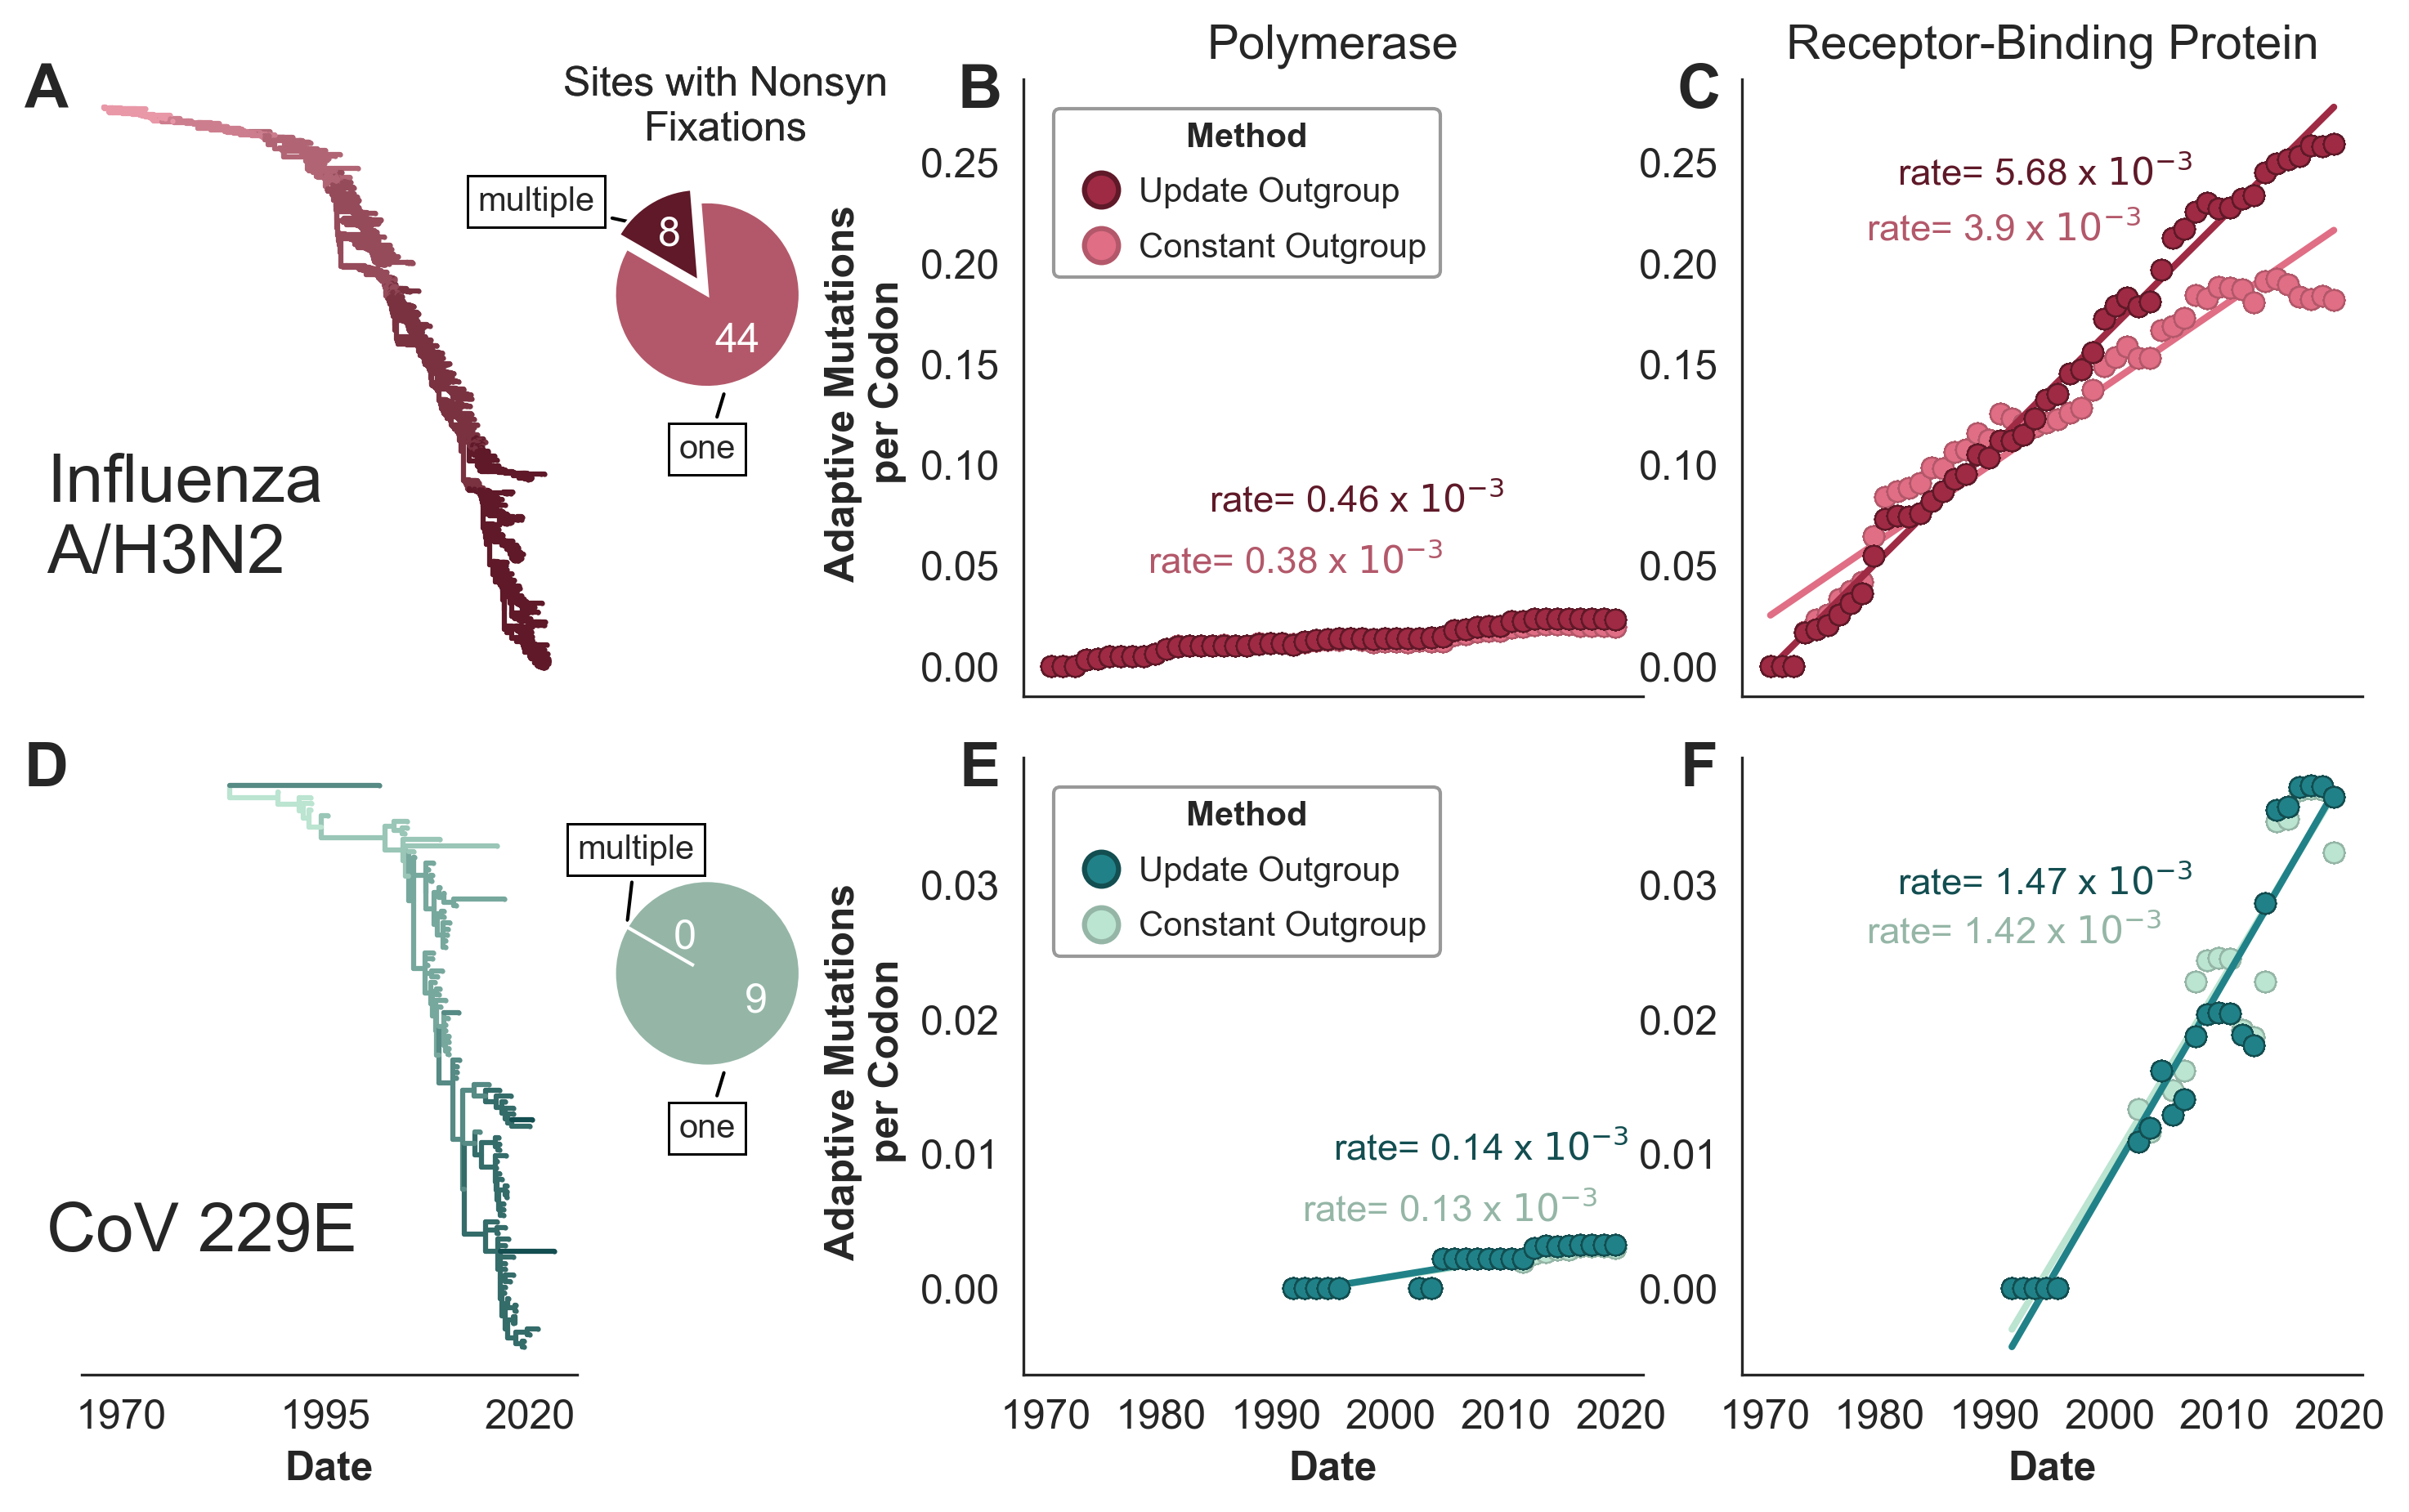

In [392]:
combine_fig_panels(['h3n2', '229e'], filename='manuscript_figures/Figure1.png')